In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.metrics import MeanSquaredError
from keras.layers import Bidirectional, Dense, LSTM, RepeatVector, TimeDistributed


%matplotlib notebook
%matplotlib inline

2023-11-15 11:29:34.379907: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 11:29:34.513374: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 11:29:34.513433: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 11:29:34.513499: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-15 11:29:34.531574: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 11:29:34.532617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# fix random seed for reproducibility
np.random.seed(9)

In [3]:
# date parser
parser = lambda date: pd.to_datetime(date, format='%Y-%m-%d %H:%M')

# load the dataset
dataframe = pd.read_csv(
    'final_AFIT_data.csv', parse_dates=[0],
    index_col=[0], date_parser=parser, engine='python'
)

## Note:

Divide dataset in to two: train_set (from 2021-01-28 to 2022-10-17), and test_set (from 2022-10-18 to 2023-08-27).
Divide train_set into 4, use 3/4 for model training and 1/4 for validation.
predict 2018 and compare results.

In [4]:
dataframe.head(5)

,ENERGY CONSUMPTION,TEMPERATURE(C),PRESSURE,HUMIDITY,WEATHER CODE,WIND DIRECTION(DEGREE),WIND SPEED(KMPH),WORKDAY,PUBLIC HOLIDAY
DATE(HOURS/DAY/MONTH/YEAR),,,,,,,,,
2021-01-28 00:00:00,1275,24,1011,16,113,53,14,1,0
2021-01-28 01:00:00,1220,23,1011,15,113,55,15,1,0
2021-01-28 02:00:00,1334,23,1011,15,113,57,16,1,0
2021-01-28 03:00:00,1298,22,1011,14,113,59,17,1,0
2021-01-28 04:00:00,1266,21,1011,13,113,61,17,1,0


In [5]:
training, testing = dataframe.loc[:'2022-10-17'], dataframe.loc['2022-10-18':]

In [6]:
training

,ENERGY CONSUMPTION,TEMPERATURE(C),PRESSURE,HUMIDITY,WEATHER CODE,WIND DIRECTION(DEGREE),WIND SPEED(KMPH),WORKDAY,PUBLIC HOLIDAY
DATE(HOURS/DAY/MONTH/YEAR),,,,,,,,,
2021-01-28 00:00:00,1275,24,1011,16,113,53,14,1,0
2021-01-28 01:00:00,1220,23,1011,15,113,55,15,1,0
2021-01-28 02:00:00,1334,23,1011,15,113,57,16,1,0
2021-01-28 03:00:00,1298,22,1011,14,113,59,17,1,0
2021-01-28 04:00:00,1266,21,1011,13,113,61,17,1,0
...,...,...,...,...,...,...,...,...,...
2022-10-17 19:00:00,1620,27,1012,44,113,48,6,1,0
2022-10-17 20:00:00,1638,25,1013,45,113,56,6,1,0
2022-10-17 21:00:00,1620,24,1014,45,113,64,6,1,0


In [7]:
testing

,ENERGY CONSUMPTION,TEMPERATURE(C),PRESSURE,HUMIDITY,WEATHER CODE,WIND DIRECTION(DEGREE),WIND SPEED(KMPH),WORKDAY,PUBLIC HOLIDAY
DATE(HOURS/DAY/MONTH/YEAR),,,,,,,,,
2022-10-18 00:00:00,1545,21,1014,49,113,113,5,1,0
2022-10-18 01:00:00,1555,21,1014,54,113,127,5,1,0
2022-10-18 02:00:00,1607,20,1013,59,113,140,5,1,0
2022-10-18 03:00:00,1544,20,1013,63,113,154,5,1,0
2022-10-18 04:00:00,1569,20,1013,65,113,164,5,1,0
...,...,...,...,...,...,...,...,...,...
2023-08-27 19:00:00,1704,23,1012,97,353,235,11,0,0
2023-08-27 20:00:00,1681,23,1013,97,248,235,8,0,0
2023-08-27 21:00:00,1601,22,1014,97,353,223,10,0,0


# Note: Dataset splitting

* ## Training
    * 3/4 => trainT or trainTra
    * 1/4 => trainV or trainVal
* ## Testing
    * test

In [8]:
def split_train_set():
    # Split into 3/4 and 1/4
    trainT, trainV = training[:'2022-05-13'], training['2022-05-14':]
    # 3/4 for training
    XtrainT, YtrainT = trainT.drop(['ENERGY CONSUMPTION'], axis=1).values, trainT['ENERGY CONSUMPTION'].values
    XtrainT, YtrainT = XtrainT.reshape(len(XtrainT), 1, 8), YtrainT.reshape(len(YtrainT), 1, 1)
    # 1/4 for validation
    XtrainV, YtrainV = trainV.drop(['ENERGY CONSUMPTION'], axis=1).values, trainV['ENERGY CONSUMPTION'].values
    XtrainV, YtrainV = XtrainV.reshape(len(XtrainV), 1, 8), YtrainV.reshape(len(YtrainV), 1, 1)
    
    return XtrainT, YtrainT, XtrainV, YtrainV

In [9]:
trainTraX, trainTraY, trainValX, trainValY = split_train_set()

In [10]:
def split_test_set():
    testX, testY = testing.drop(['ENERGY CONSUMPTION'], axis=1).values, testing['ENERGY CONSUMPTION'].values
    testX = testX.reshape(len(testX), 1, 8)
    return testX, testY

In [11]:
testX, testY = split_test_set()

# Model definition

#### Note: Activate the next 4 cells to run a fresh training and save the model

model.save('afit-stacked-encoder-decoder-lstm-model.keras')

#### Note: Make sure to deactivate the next 4 cells if you're runing a fresh training

In [12]:
model = load_model('afit-stacked-encoder-decoder-lstm-model.keras')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             11800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 50)             0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             20200     
                                                                 
 lstm_3 (LSTM)               (None, 1, 50)             20200     
                                                                 
 time_distributed (TimeDist  (None, 1, 1)              51        
 ributed)                                               

In [14]:
trainPredict = model.predict(trainTraX)

354/354 [==============================] - 5s 10ms/step


In [15]:
# Training input
trainX = dataframe.loc[:'2022-05-13']['ENERGY CONSUMPTION'].values
# Training prediction
trainPredict = trainPredict.reshape(len(trainPredict),)

In [16]:
def mean_squared_error(x, y):
    m = MeanSquaredError()
    m.update_state(x, y)
    return m.result().numpy()

In [17]:
def root_mean_square_error(actual, predicted):
    rmse_score = math.sqrt(mean_squared_error(actual, predicted))
    print('Root Mean Square Error (RMSE) Score: {0:.2f}'.format(rmse_score))

In [18]:
def mean_average_error(actual, predicted):
    mae_score = (actual - predicted).sum() / len(actual)
    print('Mean Average Error (MAE) Score: {0:.2f}'.format(abs(mae_score)))

In [19]:
def mean_average_percentage_error(actual, predicted):
    mape_score = (actual - predicted).sum() / len(actual) * 100
    print('Mean Average Percentage Error (MAPE) Score: {0:.2f}'.format(abs(mape_score)))

In [20]:
def normalised_root_mean_square_error(actual, predicted):
    rmse_score = math.sqrt(mean_squared_error(actual, predicted))
    score = rmse_score / (max(predicted) - min(predicted))
    print('Normalised Root Mean Square Error (NRMSE) Score: {0:.4f}'.format(abs(score)))

In [21]:
# MSE score for training
print('Mean Square Error (MSE) Score: {0:.2f}'.format(mean_squared_error(trainX, trainPredict)))

Mean Square Error (MSE) Score: 21549.72


In [22]:
# NRMSE score for training
normalised_root_mean_square_error(trainX, trainPredict)

Normalised Root Mean Square Error (NRMSE) Score: 0.3549


In [23]:
# NRMSE score for training
normalised_root_mean_square_error(trainX, trainPredict)

Normalised Root Mean Square Error (NRMSE) Score: 0.3549


In [24]:
# MAE score for training
mae_score = (trainX - trainPredict).sum() / len(trainX)
print('Prediction Mean Average Error (MAE) Score: {0:.2f}'.format(abs(mae_score)))

Prediction Mean Average Error (MAE) Score: 14.36


In [25]:
# MAPE score for training
mean_average_percentage_error(trainX, trainPredict)

Mean Average Percentage Error (MAPE) Score: 1435.52


In [26]:
def prepare_date(from_date, to_date=None):
    # Input data for prediction
    inputX = dataframe.loc[from_date].drop(['ENERGY CONSUMPTION'], axis=1).values
    # Actual consumption to be compared to prediction results
    inputY = dataframe.loc[from_date]['ENERGY CONSUMPTION'].values
    
    if to_date:
        inputX = dataframe.loc[from_date:to_date].drop(['ENERGY CONSUMPTION'], axis=1).values
        inputY = dataframe.loc[from_date:to_date]['ENERGY CONSUMPTION'].values
    
    inputX = inputX.reshape(len(inputX), 1, 8)
    
    return inputX, inputY

In [27]:
def forecast_load(from_date, to_date=None):
    # pred_input => Prediction Input
    # actual => Actual consumption to be compared to prediction result
    pred_input, actual = prepare_date(from_date)
    
    if to_date:
        pred_input, actual = prepare_date(from_date, to_date)
    
    predicted = model.predict(pred_input)
    predicted = predicted.reshape(len(predicted),)
    
    return actual, predicted

In [28]:
x, y = forecast_load('2022-10-18', '2023-08-27')

236/236 [==============================] - 2s 9ms/step


In [29]:
# MSE score for prediction
print('Mean Square Error (MSE) Score: {0:.2f}'.format(mean_squared_error(x, y)))

Mean Square Error (MSE) Score: 17457.75


In [30]:
# NRMSE score for prediction
root_mean_square_error(x, y)

Root Mean Square Error (RMSE) Score: 132.13


In [31]:
# NRMSE score for prediction
normalised_root_mean_square_error(x, y)

Normalised Root Mean Square Error (NRMSE) Score: 0.2966


In [32]:
# MAE score for prediction
mean_average_error(x, y)

Mean Average Error (MAE) Score: 65.57


In [33]:
# MAPE score for prediction
mean_average_percentage_error(x, y)

Mean Average Percentage Error (MAPE) Score: 6556.73


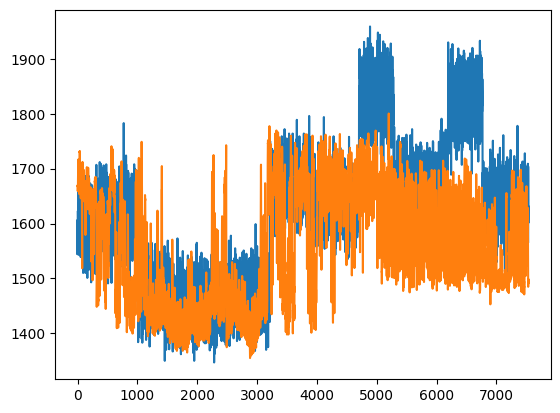

In [34]:
plt.plot(x)
plt.plot(y)
plt.show()

# Plots

In [35]:
def normalize_predicted_dataset(payload):
    date_index = dataframe.index[len(dataframe) - len(y):]
    predicted = pd.DataFrame(payload)
    predicted['Date'] = date_index
    predicted = predicted.set_index('Date')
    predicted.columns = ['Energy Consumption']
    return predicted

In [36]:
predicted = normalize_predicted_dataset(y)

In [37]:
actual = pd.DataFrame(dataframe.loc['2022-10-18':]['ENERGY CONSUMPTION'])

In [38]:
MONTH_NAMES = [
    'January', 'February', 'March', 'April', 'May', 'June', 'July',
    'August', 'September', 'October', 'November', 'December'
]
MONTH_INDEX = [
    '2023-01', '2023-02', '2023-03', '2023-04',
    '2023-05', '2023-06', '2023-07', '2023-08',
    '2022-09', '2022-10', '2022-11', '2022-12'
]
SEASON_NAMES = [
    'Long Rainy Season', 'Short Dry Season',
    'First Half Of Long Dry Season',
    'Second Half Of Long Dry Season'
]
SEASON_INDEX = [
    '2023-03:2023-07', '2023-08',
    '2023-01:2023-02', '2022-10-22:2022-12'
]

In [39]:
def plot_monthly(test_data, prediction):
    month = int(input('Enter month: e.g 1 \n'))
    if month == 9:
        return "September data is not available"

    %matplotlib notebook
    %matplotlib inline
    figure, axis = plt.subplots(figsize=(9, 5.8))
    axis.plot(test_data.loc[MONTH_INDEX[month-1]], label='Actual Consumption')
    axis.plot(prediction.loc[MONTH_INDEX[month-1]], label='Predicted Consumption', c='orange')
    axis.set_xlabel("Date", fontsize=14)
    axis.set_ylabel("Energy", fontsize=14)
    plt.title("Energy Consumption, " + MONTH_NAMES[month-1] +", " + MONTH_INDEX[month-1][:4], fontsize=18)
    plt.legend()
    figure.autofmt_xdate()
    return plt.show()


def plot_seasonal(test_data, prediction):
    season = int(input(
    '''
        1. Long Rainy Season
        2. Short Dry Season
        3. First Half Of Long Dry Season
        4. Second Half Of Long Dry Season

        Enter season from above list:
    '''))

    %matplotlib notebook
    %matplotlib inline
    figure, axis = plt.subplots(figsize=(9, 5.8))
    if ':' in SEASON_INDEX[season-1]:
        index_list = SEASON_INDEX[season-1].split(':')
        axis.plot(test_data.loc[index_list[0]:index_list[1]], label='Actual Consumption')
        axis.plot(prediction.loc[index_list[0]:index_list[1]], label='Predicted Consumption', c='orange')
    else:
        axis.plot(test_data.loc[SEASON_INDEX[season-1]], label='Actual Consumption')
        axis.plot(prediction.loc[SEASON_INDEX[season-1]], label='Predicted Consumption', c='orange')
    axis.set_xlabel("Date", fontsize=14)
    axis.set_ylabel("Energy", fontsize=14)
    plt.title(SEASON_NAMES[season-1] +", " + SEASON_INDEX[season-1][:4], fontsize=18)
    plt.legend()
    figure.autofmt_xdate()
    return plt.show()


def plot_monthly_density(test_data, prediction):
    month = int(input('Enter month: e.g 1 \n'))
    if month == 9:
        return "September data is not available"
    
    test_plot_data = test_data.loc[MONTH_INDEX[month-1]].reset_index()
    prediction_plot_data = prediction.loc[MONTH_INDEX[month-1]].reset_index()

    %matplotlib notebook
    %matplotlib inline
    figure, axis = plt.subplots(figsize=(9, 5.8))
    fig = sns.kdeplot(
        test_plot_data['ENERGY CONSUMPTION'].values,
        bw_method=8, color="blue", fill=True, label='Actual Consumption'
    )
    fig = sns.kdeplot(
        prediction_plot_data['Energy Consumption'].values,
        bw_method=8, color="orange", fill=True, label='Predicted Consumption'
    )
    plt.xlabel('Energy')
    plt.ylabel("Density")
    plt.title(MONTH_NAMES[month-1] +", " + MONTH_INDEX[month-1][:4], fontsize=18)
    return plt.show()


def plot_seasonal_density(test_data, prediction):
    season = int(input(
    '''
        1. Long Rainy Season
        2. Short Dry Season
        3. First Half Of Long Dry Season
        4. Second Half Of Long Dry Season

        Enter season from above list:
    '''))

    %matplotlib notebook
    %matplotlib inline
    figure, axis = plt.subplots(figsize=(9, 5.8))
    if ':' in SEASON_INDEX[season-1]:
        index_list = SEASON_INDEX[season-1].split(':')
        test_plot_data = test_data.loc[index_list[0]:index_list[1]].reset_index()
        prediction_plot_data = prediction.loc[index_list[0]:index_list[1]].reset_index()
        fig = sns.kdeplot(
            test_plot_data['ENERGY CONSUMPTION'].values,
            bw_method=8, color="blue", fill=True, label='Actual Consumption'
        )
        fig = sns.kdeplot(
            prediction_plot_data['Energy Consumption'].values,
            bw_method=8, color="orange", fill=True, label='Predicted Consumption'
        )
    else:
        test_plot_data = test_data.loc[SEASON_INDEX[season-1]].reset_index()
        prediction_plot_data = prediction.loc[SEASON_INDEX[season-1]].reset_index()
        fig = sns.kdeplot(
            test_plot_data['ENERGY CONSUMPTION'].values,
            bw_method=8, color="blue", fill=True, label='Actual Consumption'
        )
        fig = sns.kdeplot(
            prediction_plot_data['Energy Consumption'].values,
            bw_method=8, color="orange", fill=True, label='Predicted Consumption'
        )
    plt.xlabel('Energy')
    plt.ylabel("Density")
    plt.title(SEASON_NAMES[season-1] +", " + SEASON_INDEX[season-1][:4], fontsize=18)
    plt.legend()
    return plt.show()



        1. Long Rainy Season
        2. Short Dry Season
        3. First Half Of Long Dry Season
        4. Second Half Of Long Dry Season

        Enter season from above list:
     2


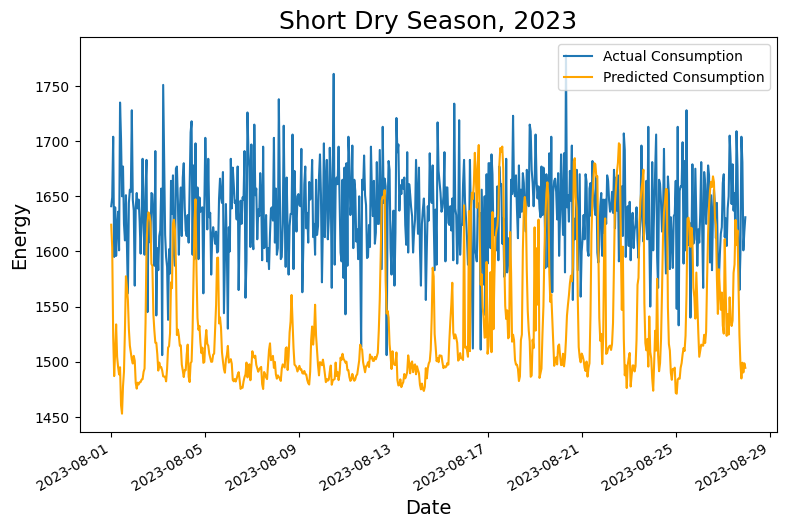

In [40]:
plot_seasonal(actual, predicted)